In [1]:
# !poetry run pip install -U git+https://github.com/ichko/aesthetic-tensor

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from kornia import augmentation

from tqdm.auto import tqdm
import base64
import matplotlib
from io import BytesIO
from PIL import Image
from IPython.display import HTML
import mediapy as mpy
import os

In [3]:
from aesthetic_tensor import monkey_patch_torch
monkey_patch_torch()

In [4]:
from nca.utils import conv_same

In [5]:
W, H = 128, 64

In [6]:
import cv2

pad = 55
screen = np.zeros((H, W))
cv2.line(screen, [pad, H // 2], [W - pad - 0, H // 2], color=1, thickness=5)

line_screen = torch.tensor(screen, dtype=torch.float32)
line_screen.ae.zoom(2).img

In [117]:
screen = np.zeros((H, W))
pad = 1

cv2.line(screen, [W // 2, 0], [W // 2, H // 2 - pad], color=1, thickness=1)
# cv2.line(screen, [W // 2 + 1, 0], [W // 2 + 1, H // 2 - pad], color=1, thickness=1)
# cv2.line(screen, [W // 2 - 1, 0], [W // 2 - 1, H // 2 - pad], color=1, thickness=1)

cv2.line(screen, [W // 2, H // 2 + pad], [W // 2, H], color=1, thickness=1)
# cv2.line(screen, [W // 2 + 1, H // 2 + pad], [W // 2 + 1, H], color=1, thickness=1)
# cv2.line(screen, [W // 2 - 1, H // 2 + pad], [W // 2 - 1, H], color=1, thickness=1)

divider_screen = torch.tensor(screen, dtype=torch.float32)
divider_screen.ae.zoom(2).img

In [8]:
class SimpleNCA(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        perc = 3
        hid = 128
        self.chans = 8

        self.seed = nn.Parameter(torch.rand(self.chans, 64, 64) * 2 - 1)
        self.kernel = nn.Sequential(
            nn.Dropout2d(p=0.1),
            conv_same(self.chans, perc * self.chans, ks=5, bias=True, padding_mode="circular"),
            nn.BatchNorm2d(perc * self.chans),
        )
        
        sobel_x = torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]])/8
        sobel_y = torch.tensor([[1.0,2.0,1.0],[0.0,0.0,0.0],[-1.0,-2.0,-1.0]])/8
        identity = torch.tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]])
        lap = torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])

        all_filters = torch.stack((identity, sobel_x, sobel_y))
        all_filters_batch = all_filters.repeat(self.chans, 1, 1).unsqueeze(1)
        self.all_filters_batch = nn.Parameter(all_filters_batch, requires_grad=False)
        
        self.rule = nn.Sequential(
            conv_same(perc * self.chans, hid, ks=1, bias=True),
            nn.ReLU(),
            conv_same(hid, self.chans, ks=1, bias=False),
        )

        nn.init.zeros_(self.rule[-1].weight)

    def forward(self, x, steps=1):
        seq = [x]
        device = next(self.parameters()).device
        x *= 1 - divider_screen.to(device)
        for i in range(steps):
            old_x = x
            x = F.conv2d(
#                 F.pad(x, (1, 1, 1, 1), "circular"),
                F.pad(x, (1, 1, 1, 1), "constant", 0),
                self.all_filters_batch,
                stride=1,
                padding=0,
                groups=self.chans,
            )
            x = self.rule(x)
            x = old_x + x
            x *= 1 - divider_screen.to(device)
            
            seq.append(x)

        seq = torch.stack(seq, axis=1)
        return seq

In [9]:
import torchsummary

In [10]:
nca = SimpleNCA().to("cpu")

In [11]:
inp1 = torch.rand(2, nca.chans, H, W) * 2 - 1
inp2 = torch.zeros(1, nca.chans, H, W)
inp2[0, 0, 32, 32] = 1

inp3 = torch.ones(1, nca.chans, H, W)
inp3[0, 0, 32, 32] = 0

inp = torch.cat([inp1, inp2, inp3])

out = nca(inp, steps=20)
out.ae

float32<4, 21, 8, 64, 128>∈[-1.000, 1.000] | μ=0.249, σ=0.592

In [12]:
torchsummary.summary(nca.to("cuda"), input_size=inp1.size()[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 128, 64, 128]           3,200
              ReLU-2         [-1, 128, 64, 128]               0
            Conv2d-3           [-1, 8, 64, 128]           1,024
Total params: 4,224
Trainable params: 4,224
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 16.50
Params size (MB): 0.02
Estimated Total Size (MB): 16.77
----------------------------------------------------------------



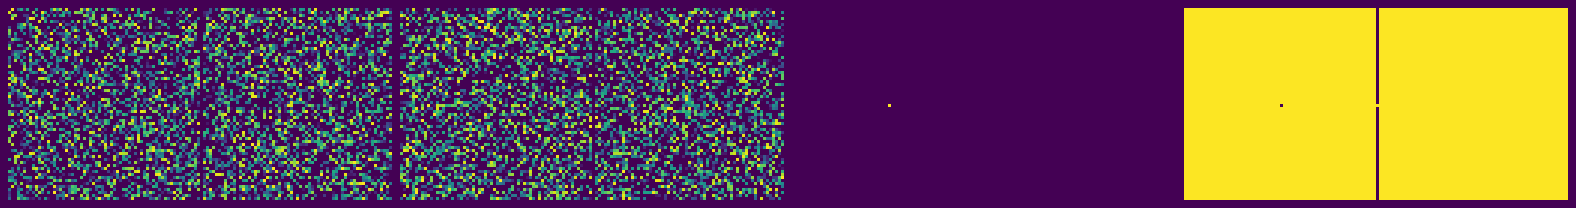

In [13]:
out.ae.zoom(3).grid(ncols=4, pad=4)[:, 0].gif(fps=24)

In [14]:
out.ae

float32<4, 21, 8, 64, 128>∈[-1.000, 1.000] | μ=0.249, σ=0.592

In [15]:
from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchdata.datapipes.iter import IterableWrapper

In [16]:
num_classes = 10
ds = MNIST(root="./.data", download=True, transform=ToTensor(), train=True)

In [17]:
bs = 8
dl = DataLoader(IterableWrapper(ds).filter(lambda x: x[1] < num_classes), batch_size=bs, shuffle=True)

/home/iz/.cache/pypoetry/virtualenvs/nca-ar8j7Liq-py3.10/lib/python3.10/site-packages/torch/utils/data/datapipes/utils/common.py:145: UserWarning: Lambda function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(
/home/iz/.cache/pypoetry/virtualenvs/nca-ar8j7Liq-py3.10/lib/python3.10/site-packages/torch/utils/data/graph_settings.py:90: UserWarning: `shuffle=True` was set, but the datapipe does not contain a `Shuffler`. Adding one at the end. Be aware that the default buffer size might not be sufficient for your task.
  warnings.warn(


In [18]:
batch = next(iter(dl))

In [19]:
np.arange(0, 100, 10)

array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90])

In [20]:
def map_input(dl):
    it = iter(dl)
    for x, y in it:
        bs, _, h, w = x.shape
        c = nca.chans
        inp_screen = torch.zeros(bs, c, H, W)
        pad = 30
        inp_screen[
            :, :1,
            H // 2 - h // 2:H // 2 + h // 2,
            pad - w // 2:pad + w // 2,
        ] = x
        outs = []
        for t in np.arange(30, 100, 5):
            pad = t
            out_screen = torch.zeros(bs, 1, H, W)
            out_screen[
                :, :1,
                H // 2 - h // 2:H // 2 + h // 2,
                pad - w // 2:pad + w // 2,
            ] = x
            outs.append(out_screen)
        yield {"inp": inp_screen, "out": outs, "cls": y}

In [21]:
gen = map_input(dl)
batch = next(gen)
x, y = batch["inp"], batch["out"]
print(len(y))
y = y[-1]

torch.cat([x[:8, :1], y[:8, :1]]).ae.cmap(dim=2).grid()[0, :3].img

14


In [22]:
nca.to("cpu")(x).ae

float32<8, 2, 8, 64, 128>∈[0.000, 1.000] | μ=0.002, σ=0.036

In [23]:
def optim_step(i, nca, batch, optim, device, grad_clip_val=0.1):
    x, ys = batch["inp"], batch["out"]
    x = x.to(device)
    ys = [y.to(device) for y in ys]
    N = len(ys)
    bs = x.shape[0]
    out = nca(x, steps=100)

    loss = 0
    for i, y in enumerate(ys):
        if i < 1 or i >= N - 1:
            target_out = out[:, 5 + i * 5, :1]
            loss += F.mse_loss(target_out, y)

    if nca.training:
        optim.zero_grad()
        loss.backward()
        optim.step()
    
    return loss, out

In [24]:
from copy import deepcopy

In [25]:
lr = 0.0001
target_nca = deepcopy(nca)
history = []

In [26]:
fns = os.listdir("checkpoints-ae")
losses = [float(f.split("Lf")[1].split(".pkl")[0]) for f in fns]
idxs = [int(f.split("model-")[1].split("-")[0]) for f in fns]
target_idx = np.argsort(idxs)[-1]
min_loss_file = fns[target_idx]
min_loss_file

'model-230250-Lf0.015245.pkl'

In [27]:
with open(f"checkpoints-ae/{min_loss_file}", "rb") as fp:
    target_nca = torch.load(fp)

In [28]:
optim = torch.optim.Adam(target_nca.parameters(), lr=lr)

In [29]:
device = "cuda"
target_nca = target_nca.to(device)

In [30]:
target_nca = target_nca.eval()
with torch.no_grad():
    _ = optim_step(0, target_nca, batch, optim, device)

In [31]:
torch.autograd.set_detect_anomaly(True)

In [32]:
# target_nca.kernel[0].padding_mode = "circular"

In [33]:
# !rm -rf checkpoints-ae/

In [34]:
save_dir = "checkpoints-ae-1px"
img_dir = "imgs-ae-1px"
os.makedirs(save_dir, exist_ok=True)
os.makedirs(img_dir, exist_ok=True)

In [35]:
# from IPython.display import clear_output

# E = len(history)
# pbar = tqdm(range(E, E + 80_000))

# target_nca = target_nca.train()
# for i in pbar:
#     try:
#         batch = next(gen)
#     except StopIteration as err:
#         gen = map_input(dl)
#         continue

#     loss, out = optim_step(i, target_nca, batch, optim, device)
#     pbar.set_description(f"Loss: {loss:.10f}")
#     history.append(loss.item())

#     if i % 250 == 0:
#         clear_output(wait=True)
#         display(pbar.container)
#         plt.plot(history)
#         plt.yscale("log")
#         plt.show()

#         with torch.no_grad():
#             t = torch.tensor(out[:8, :, 0].ae.cmap("bwr", dim=2).raw)
#             t = t * (255 - 255 * divider_screen[None, None, None])
#             gif = t.ae.grid(ncols=4, pad=4)[:, :3].zoom(3).gif(fps=24)
#             gif.save(f"{img_dir}/img_{i:07}.gif")

#             with open(os.path.join(save_dir, f"model-{i:07}-Lf{loss.item():0.6f}.pkl"), "wb+") as fp:
#                 torch.save(target_nca, fp)

In [135]:
fns = os.listdir("checkpoints-ae-1px/")
losses = [float(f.split("Lf")[1].split(".pkl")[0]) for f in fns]
idxs = [int(f.split("model-")[1].split("-")[0]) for f in fns]
target_idx = np.argsort(idxs)[-1]
min_loss_file = fns[target_idx]

with open(f"checkpoints-ae-1px/{min_loss_file}", "rb") as fp:
    target_nca = torch.load(fp)
    
optim = torch.optim.Adam(target_nca.parameters(), lr=lr)

In [136]:
with torch.no_grad():
    batch = next(gen)
    target_nca = target_nca.eval()
    loss, out = optim_step(0, target_nca, batch, optim, device)

In [137]:
out[:8, :, 0].ae.cmap(dim=2)

uint8<8, 101, 4, 64, 128>∈[1.000, 255.000] | μ=103.162, σ=93.477

In [138]:
t = torch.tensor(out[:8, :, 0].ae.cmap("Greys", dim=2).raw)
t = t * (255 - 255 * divider_screen[None, None, None])
t.ae.grid(ncols=4, pad=4)[:, :3].zoom(3).gif(fps=24).save("a.gif")


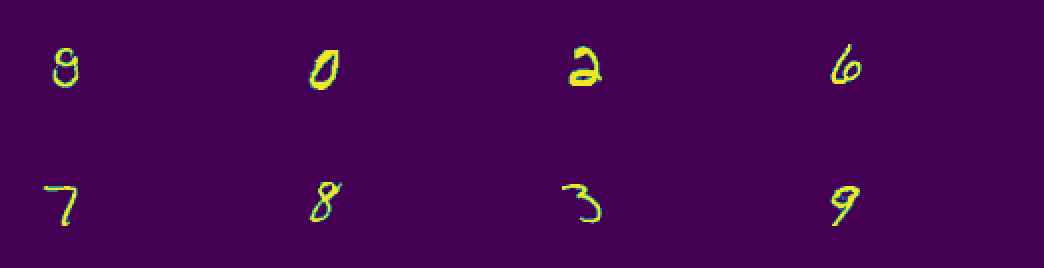

In [139]:
gif = out[:16].ae.zoom(2).grid(ncols=4, pad=2)[:, 0].gif(fps=24)
gif

In [140]:
import gc
def clean_mem():
    torch.cuda.empty_cache()
    gc.collect()
    
clean_mem()

In [141]:
# checkpoint_names = os.listdir("./checkpoints2/")
# losses = [float(c.split("Lf")[1].split(".pkl")[0]) for c in checkpoint_names]

# ml = min(losses)
# min_loss_checkpoint_name = [c for c in checkpoint_names if str(ml) in c][0]
# min_loss_nca = torch.load(f"./checkpoints2/{min_loss_checkpoint_name}")

# min_loss_checkpoint_name

In [142]:
# target_nca = min_loss_nca

In [143]:
device = "cuda"

In [144]:
bs = 8

ds = MNIST(root="./.data", download=True, transform=ToTensor(), train=True)
dl = DataLoader(IterableWrapper(ds).filter(lambda x: x[1] < num_classes), batch_size=bs, shuffle=True)
gen = map_input(dl)

In [145]:
cls_outs = {}
cls_ins = {}
target_nca.eval()
with torch.inference_mode():
    for i in tqdm(range(10)):
        batch = next(gen)
        x = batch["inp"].to("cuda")
        cls = batch["cls"]
        out = target_nca(x, steps=100)
        for c in range(num_classes):
            cls_mask = cls.to("cuda") == c
            if cls_mask.sum() > 0:
                cls_out = out[cls_mask]
                cls_in = [y.to("cuda")[cls_mask] for y in batch["out"]]
                cls_outs.setdefault(c, []).append(cls_out)
                cls_ins.setdefault(c, []).append(cls_in)

  0%|          | 0/10 [00:00<?, ?it/s]

In [146]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [158]:
torch.cat(cls_ins[5][0])[[12, 13], 0].ae.zoom(2) \
    .cmap("binary", dim=1).grid(pad=2, ncols=2)[:3].hwc.img

In [148]:
cls_outs[5][0][0].ae

float32<101, 8, 64, 128>∈[-11.245, 10.498] | μ=0.315, σ=1.061

In [149]:
out = []
for i in range(num_classes):
    o = cls_outs[i][0][0, :, :]
    out.append(o)
out = torch.stack(out)


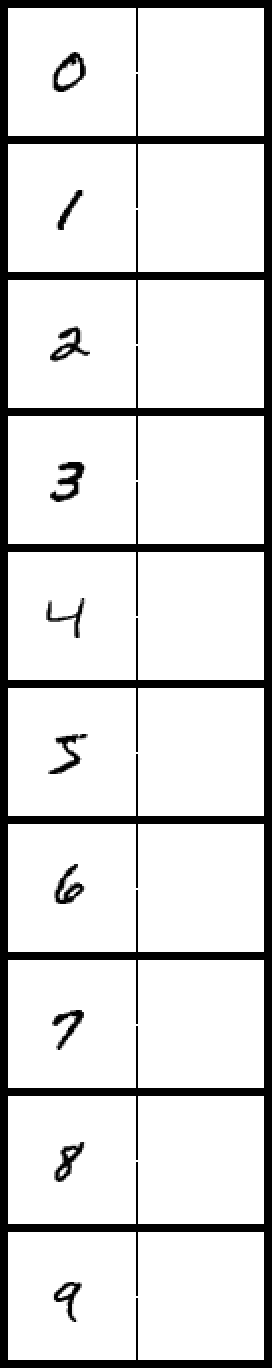

In [150]:
t = torch.tensor(out[:10, :, 0].ae.cmap("binary", dim=2).raw)
t = t * (255 - 255 * divider_screen[None, None, None])
t.ae.grid(ncols=1, pad=2)[:, :3].zoom(2).gif(fps=24)

In [151]:
t.ae

float32<10, 101, 4, 64, 128>∈[0.000, 65025.000] | μ=63994.360, σ=7123.318

In [152]:
t.ae[5, [0, 20, 40, 65, 75], :3].grid(ncols=5).zoom(3).img

In [153]:
t.ae.grid(ncols=1, pad=2)[[3, 20, 35, 44, 60, 75], :3].zoom(1).grid(ncols=6).img

In [154]:
t = torch.tensor(out[:10, :, :16].ae.cmap("bwr", dim=2).raw)
t = t * (255 - 255 * divider_screen[None, None, None, None])

In [155]:
# t.permute(0, 3, 1, 2, 4, 5).ae.grid(ncols=1, pad=1).grid(ncols=8, pad=1)[:, :3].zoom(1).gif(fps=20)

## Calc reconstruction

In [111]:
bs = 1

ds = MNIST(root="./.data", download=True, transform=ToTensor(), train=True)
dl = DataLoader(IterableWrapper(ds).filter(lambda x: x[1] < num_classes), batch_size=bs, shuffle=False)
gen = map_input(dl)

In [112]:
device = "cuda"

target_nca = target_nca.eval().to(device)
last_frame = 5 + len(batch["out"]) * 5
last_frame

75

In [113]:
losses = []
rmses = []

best_outs = {}
min_losses = {}

with torch.no_grad():
    for batch in tqdm(gen, total=len(ds) // bs):
        loss, out = optim_step(0, target_nca, batch, optim, device)
        loss = loss.item()
        losses.append(loss)
        
        target_out = out[:, last_frame, :1].to(device)
        y = batch["out"][-1].to(device)
        rmse = torch.sqrt(((target_out - y) ** 2).mean())
        rmses.append(rmse.item())

        cls = batch['cls'][0].item()
        min_loss = min_losses.get(cls, 100)
        if loss < min_loss:
            min_losses[cls] = loss
            best_outs[cls] = out.detach().cpu()

  0%|          | 0/60000 [00:00<?, ?it/s]


KeyboardInterrupt



In [ ]:
train_rmses = rmses
np.mean(train_rmses)

In [ ]:
# test_rmses = rmses
# np.mean(test_rmses) # 0.11176382170654833

In [ ]:
out = torch.cat([best_outs[i] for i in range(num_classes)])
t = torch.tensor(out[:10, :, 0].ae.cmap("binary", dim=2).raw)
t = t * (255 - 255 * divider_screen[None, None, None])
t.ae.grid(ncols=5, pad=2)[:, :3].zoom(3).gif(fps=24)

In [ ]:
# min_loses